<a href="https://colab.research.google.com/github/georgsmeinung/ast-tp/blob/main/AST_TP1_Cancelas_Filipuzzi_Gallardo_Nicolau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.austral.edu.ar/wp-content/uploads/2022/10/facultades-horizontales-03.png" width="50%" alt="Universidad Austral - Facultad de Ingeniería">

## Maestría en Ciencia de Datos 2024/2025

### Análisis de Series Temporales - Trabajo práctico N° 1

Integrantes:
- Cancelas, Martín.
-	Fiipuzzi, Juan Manuel.
-	Gallardo, Ezequiel.
-	Nicolau, Jorge.




```
https://colab.research.google.com/drive/1bwqSAtlE3GMqG3Xzi-OCgQFtivW-a9N
```



El presente trabajo aborda la necesidad del Banco Central de la República Argentina (BCRA) de contar con pronósticos robustos y confiables sobre la Circulación Monetaria, definida como el stock de billetes y monedas en poder del público y los bancos. Esta capacidad predictiva es fundamental para la óptima asignación de recursos públicos en la impresión y logística de billetes, buscando evitar tanto la escasez como el exceso de numerario y guiar la decisión de elaborar nuevas denominaciones. En el contexto económico argentino, marcado por "quiebres estructurales" y la influencia de variables como el crecimiento económico (EMAE), la política monetaria (tasa de interés) y la inflación (IPC), la precisión de estos pronósticos es vital. Las demoras pasadas en la emisión de billetes de mayor denominación han generado ineficiencias y costos adicionales para las entidades financieras, subrayando la urgencia de estas predicciones.

Para lograr estos pronósticos, el estudio se centra en el Análisis de Series Temporales, dado que la Circulación Monetaria y otras variables económicas exhiben correlación e "inercia" que requieren métodos de inferencia específicos. Una propiedad fundamental es la estacionariedad, que se evalúa mediante Funciones de Autocovarianza (FAS), Autocorrelación (FAC) y Autocorrelación Parcial (FACP), y se somete a pruebas formales de raíces unitarias (Dickey-Fuller, ADF y KPSS). Los análisis preliminares confirmaron que la Circulación Monetaria, la Tasa de Plazo Fijo y el IPC son series no estacionarias, con la primera presentando una marcada tendencia. Para la Circulación Monetaria, se aplicó una transformación logarítmica para estabilizar la varianza, seguida de una diferenciación estacional y no estacional (d=1, D=1, s=12), logrando así que la serie transformada sea estacionaria y apta para el modelado SARIMA.


### Instalación e importación de librerías necesarias para el trabajo.

In [ ]:
import requests
import pandas as pd
import urllib3
import matplotlib.pyplot as plt
import io
import numpy as np
import warnings
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.api import OLS, add_constant
from statsmodels.graphics.gofplots import qqplot
from datetime import datetime
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Obtención de series temporales con variables de interés.

In [ ]:
# Variables del BCRA: Circulación Monetaria y Tasa de Plazo Fijo a 30-44 días en TNA.
def descargar_variable(var_id, desde, hasta):
    url = f"https://api.bcra.gob.ar/estadisticas/v3.0/monetarias/{var_id}?desde={desde}&hasta={hasta}"
    resp = requests.get(url, verify=False)
    resultados = resp.json().get("results", [])
    if not resultados:
        raise ValueError(f"No se encontraron datos para la variable {var_id} en rango {desde} a {hasta}")
    df = pd.DataFrame(resultados)
    df['fecha'] = pd.to_datetime(df['fecha'])
    df.sort_values('fecha', inplace=True)
    df.set_index('fecha', inplace=True)
    return df

rangos = [
    ("2017-01-01", "2021-04-09"),
    ("2021-04-10", "2025-06-30")
]

variables = {
    67: "Billetes y Monedas en poder del público",
    68: "Billetes y Monedas en poder de las Entidades Financieras",
    128: "Tasa de Plazo Fijo a 30-44 días"
}

data = {}

for var_id, nombre in variables.items():
    try:
        df_list = []
        for desde, hasta in rangos:
            df_parcial = descargar_variable(var_id, desde, hasta)
            df_list.append(df_parcial)
        df_var = pd.concat(df_list)
        df_var = df_var[~df_var.index.duplicated(keep='first')]
        data[var_id] = df_var['valor']
        print(f"✅ {nombre} cargada correctamente, {len(df_var)} valores")
    except Exception as e:
        print(f"❌ Error al cargar la variable {nombre}, el error es: {e}")

# Circulación Monetaria.
try:
    df_combined = pd.DataFrame(data)
    df_combined['circulacion_monetaria'] = (df_combined[67] + df_combined[68]) * 1_000_000
    circulacion_mensual = df_combined['circulacion_monetaria'].resample('MS').mean()
    print(f"✅ Circulación Monetaria calculada correctamente, {len(circulacion_mensual)} valores")
except Exception as e:
    print(f"❌ Error al calcular Circulación Monetaria, el error es: {e}")

# Tasa de Plazo Fijo a 30-44 días.
try:
    tasa_pf_mensual = df_combined[128].resample('MS').mean()
    print(f"✅ Tasa de Plazo Fijo calculada correctamente, {len(tasa_pf_mensual)} valores")
except Exception as e:
    print(f"❌ Error al calcular Tasa de Plazo Fijo, el error es: {e}")

# Variables del INDEC: Indice de Precios al Consumidor a Nivel Nacional y Estimador Mensual de la Actividad Económica.
# IPC
try:
    url_ipc = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_ipc_06_25.xls"
    response_ipc = requests.get(url_ipc)
    archivo_excel = io.BytesIO(response_ipc.content)

    df_fechas = pd.read_excel(archivo_excel, header=None, skiprows=5, nrows=1)
    df_valores = pd.read_excel(archivo_excel, header=None, skiprows=9, nrows=1)
    fechas_raw = df_fechas.iloc[0, 1:]
    valores_raw = df_valores.iloc[0, 1:]
    fechas = pd.to_datetime(fechas_raw, format='%b-%y')

    ipc_df = pd.DataFrame({'fecha': fechas, 'ipc': valores_raw.values})
    ipc_df = ipc_df.dropna(subset=['ipc'])
    ipc_df['ipc'] = pd.to_numeric(ipc_df['ipc'], errors='coerce')
    ipc_df.set_index('fecha', inplace=True)
    ipc_mensual = ipc_df.resample('MS').mean()
    print(f"✅ IPC Nacional cargado correctamente, {len(ipc_mensual)} valores")
except Exception as e:
    print(f"❌ Error al cargar el IPC Nacional, el error es: {e}")

# EMAE
try:
    url_emae = "https://www.indec.gob.ar/ftp/cuadros/economia/sh_emae_mensual_base2004.xls"
    response_emae = requests.get(url_emae)
    archivo_excel = io.BytesIO(response_emae.content)

    em_raw = pd.read_excel(archivo_excel, header=None, skiprows=5, usecols="A:C")
    em_raw.columns = ['anio', 'mes', 'emae']
    em_raw['anio'] = em_raw['anio'].ffill()
    em_raw = em_raw.dropna(subset=['mes', 'emae'])

    meses_dict = {
        'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4,
        'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8,
        'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
    }

    em_raw['mes_num'] = em_raw['mes'].str.strip().map(meses_dict)
    em_raw['fecha'] = pd.to_datetime(dict(year=em_raw['anio'].astype(int),
                                          month=em_raw['mes_num'],
                                          day=1))

    start_date = pd.to_datetime("2017-01-01")
    end_date = pd.to_datetime("2025-06-30")

    emae_df = em_raw.loc[(em_raw['fecha'] >= start_date) & (em_raw['fecha'] <= end_date), ['fecha', 'emae']]
    emae_df.set_index('fecha', inplace=True)
    emae_df = emae_df.sort_index()
    print(f"✅ EMAE cargado correctamente, {len(emae_df)} valores")
except Exception as e:
    print(f"❌ Error al cargar el EMAE, el error es: {e}")

✅ Billetes y Monedas en poder del público cargada correctamente, 2000 valores
✅ Billetes y Monedas en poder de las Entidades Financieras cargada correctamente, 2000 valores
✅ Tasa de Plazo Fijo a 30-44 días cargada correctamente, 2000 valores
✅ Circulación Monetaria calculada correctamente, 101 valores
✅ Tasa de Plazo Fijo calculada correctamente, 101 valores
✅ IPC Nacional cargado correctamente, 101 valores
✅ EMAE cargado correctamente, 100 valores


In [ ]:
circulacion_mensual.head(5)

,circulacion_monetaria
fecha,
2017-02-01,5.993830e+11
2017-03-01,5.921440e+11
2017-04-01,5.903043e+11
2017-05-01,5.876660e+11
2017-06-01,6.066295e+11


### Visualización de las variables de interés.

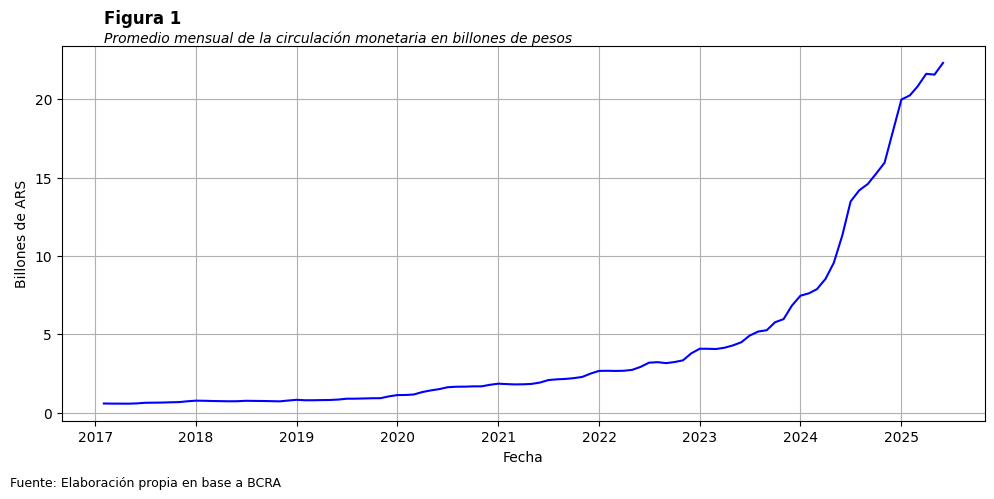

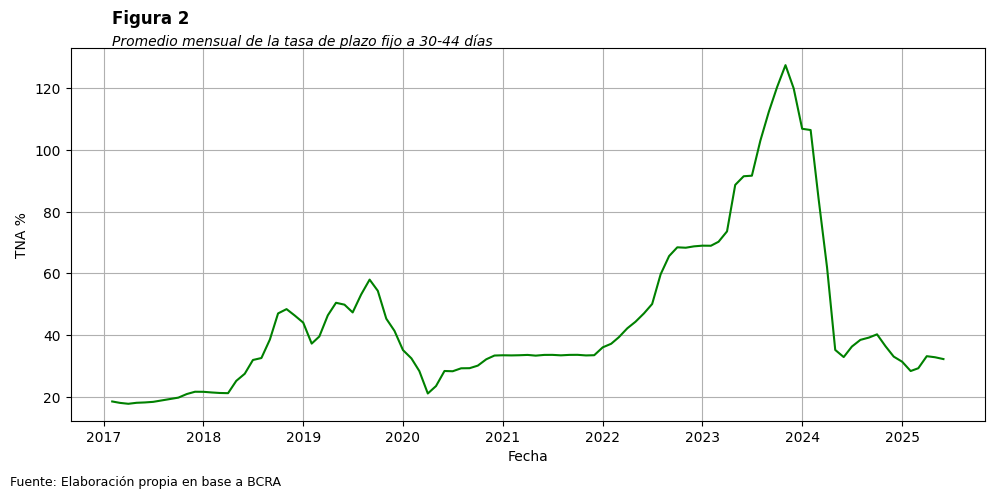

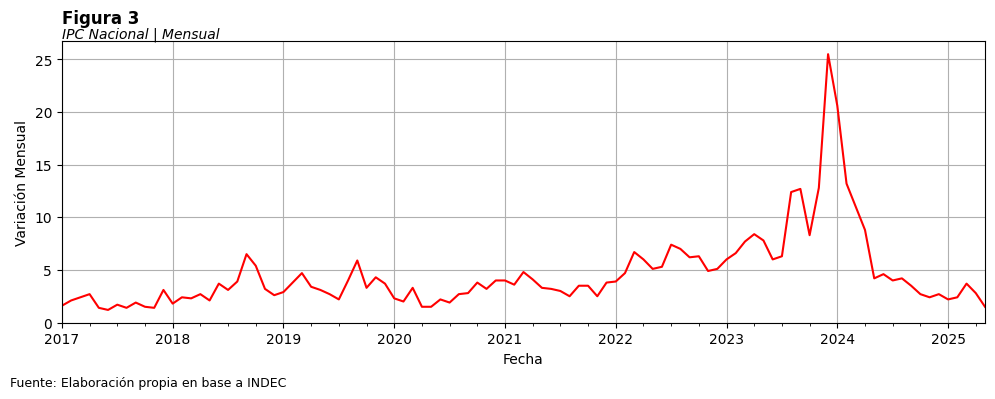

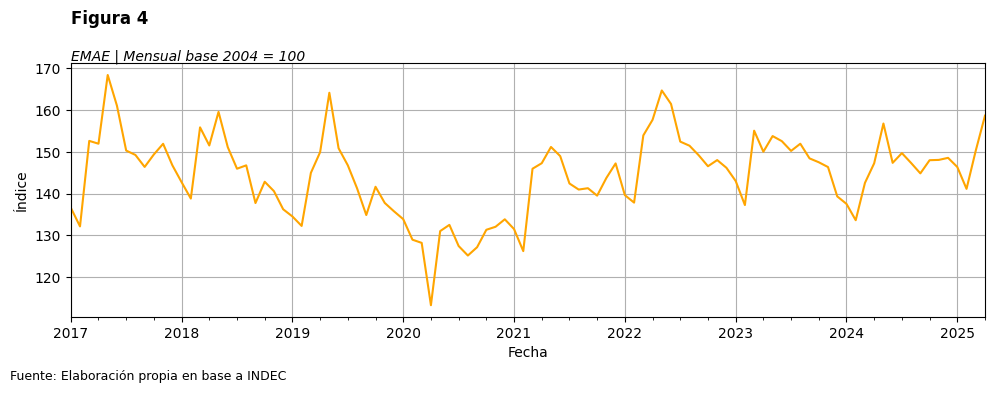

In [ ]:
# Circulación Monetaria.
plt.figure(figsize=(10,5))
plt.plot(circulacion_mensual.index, circulacion_mensual.values / 1_000_000_000_000, color='blue')
plt.title('')
plt.text(x=circulacion_mensual.index.min(), y=plt.ylim()[1]*1.05,
         s="Figura 1", fontsize=12, fontweight='bold', ha='left', va='bottom')
plt.text(x=circulacion_mensual.index.min(), y=plt.ylim()[1]*1.00,
         s="Promedio mensual de la circulación monetaria en billones de pesos", fontsize=10,
         fontstyle='italic', ha='left', va='bottom')
plt.xlabel('Fecha')
plt.ylabel('Billones de ARS')
plt.grid(True)
plt.figtext(0.01, 0.01, "Fuente: Elaboración propia en base a BCRA", fontsize=9, ha='left', va='bottom')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

# Tasa de Plazo Fijo a 30-44 días.
plt.figure(figsize=(10,5))
plt.plot(tasa_pf_mensual.index, tasa_pf_mensual.values, color='green')
plt.title('')
ylim = plt.ylim()
plt.text(x=tasa_pf_mensual.index.min(), y=ylim[1]*1.05,
         s="Figura 2", fontsize=12, fontweight='bold', ha='left', va='bottom')
plt.text(x=tasa_pf_mensual.index.min(), y=ylim[1]*1.00,
         s="Promedio mensual de la tasa de plazo fijo a 30-44 días", fontsize=10,
         fontstyle='italic', ha='left', va='bottom')
plt.xlabel('Fecha')
plt.ylabel('TNA %')
plt.grid(True)
plt.figtext(0.01, 0.01, "Fuente: Elaboración propia en base a BCRA", fontsize=9, ha='left', va='bottom')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

# IPC Nacional
fig, ax = plt.subplots(figsize=(10, 4))
ipc_mensual.plot(ax=ax, color='red', legend=False)
ax.set_title('')
ylim = ax.get_ylim()
ax.text(ipc_mensual.index.min(), ylim[1]*1.05,
        "Figura 3", fontsize=12, fontweight='bold', ha='left', va='bottom')
ax.text(ipc_mensual.index.min(), ylim[1]*1.00,
        "IPC Nacional | Mensual", fontsize=10,
        fontstyle='italic', ha='left', va='bottom')
ax.set_xlabel('Fecha')
ax.set_ylabel('Variación Mensual')
ax.grid(True)
plt.figtext(0.01, 0.01, "Fuente: Elaboración propia en base a INDEC", fontsize=9, ha='left', va='bottom')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

# EMAE
fig, ax = plt.subplots(figsize=(10, 4))
emae_df.plot(ax=ax, color='orange', legend=False)
ax.set_title('')
ylim = ax.get_ylim()
ax.text(emae_df.index.min(), ylim[1]*1.05,
        "Figura 4", fontsize=12, fontweight='bold', ha='left', va='bottom')
ax.text(emae_df.index.min(), ylim[1]*1.00,
        "EMAE | Mensual base 2004 = 100", fontsize=10,
        fontstyle='italic', ha='left', va='bottom')
ax.set_xlabel('Fecha')
ax.set_ylabel('Índice')
ax.grid(True)
plt.figtext(0.01, 0.01, "Fuente: Elaboración propia en base a INDEC", fontsize=9, ha='left', va='bottom')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

Funciones de Autocovarianzas, Autocorrelación y Autocorrelación Parcial de las variables.

In [ ]:
def autocovariance(series, lag):
    series = np.asarray(series)
    n = len(series)
    mean = np.mean(series)
    if lag >= n:
        return np.nan
    return np.sum((series[:n - lag] - mean) * (series[lag:] - mean)) / (n - lag)

def autocorrelation(series, lag):
    gamma_0 = autocovariance(series, 0)
    if gamma_0 == 0:
        return np.nan
    return autocovariance(series, lag) / gamma_0

def graficar_fac_fas_facp(serie, fig_num, titulo, subtitulo, color, lags=36):
    serie = serie.dropna()
    max_lags = min(lags, len(serie) // 2 - 1)

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # FAS
    lag_range = np.arange(1, max_lags + 1)
    autocovs = [autocovariance(serie, lag) for lag in lag_range]
    axs[0].stem(lag_range, autocovs, basefmt=" ", linefmt=color, markerfmt=color)
    axs[0].set_title('FAS - Función de Autocovarianzas', fontsize=12)
    axs[0].set_xlabel('Rezago')
    axs[0].set_ylabel('Valor')
    axs[0].grid()

    # FAC
    plot_acf(serie, lags=max_lags, ax=axs[1], alpha=0.05, color=color)
    axs[1].set_title('FAC - Función de Autocorrelación', fontsize=12)
    axs[1].set_xlabel('Rezago')
    axs[1].grid()
    for line in axs[1].lines:
        line.set_color(color)
        line.set_markerfacecolor(color)
        line.set_markeredgecolor(color)
    for patch in axs[1].collections:
        patch.set_facecolor(color)
        patch.set_alpha(0.15)

    # FACP
    plot_pacf(serie, lags=max_lags, ax=axs[2], method="ywm", alpha=0.05, color=color)
    axs[2].set_title('FACP - Función de Autocorrelación Parcial', fontsize=12)
    axs[2].set_xlabel('Rezago')
    axs[2].grid()
    for line in axs[2].lines:
        line.set_color(color)
        line.set_markerfacecolor(color)
        line.set_markeredgecolor(color)
    for patch in axs[2].collections:
        patch.set_facecolor(color)
        patch.set_alpha(0.15)

    plt.suptitle(f"Figura {fig_num}", fontsize=14, fontweight='bold', x=0.01, ha='left')
    fig.text(0.015, 0.87, subtitulo, fontsize=11, fontstyle='italic', ha='left')
    plt.tight_layout(rect=[0, 0.04, 1, 0.85])
    plt.show()

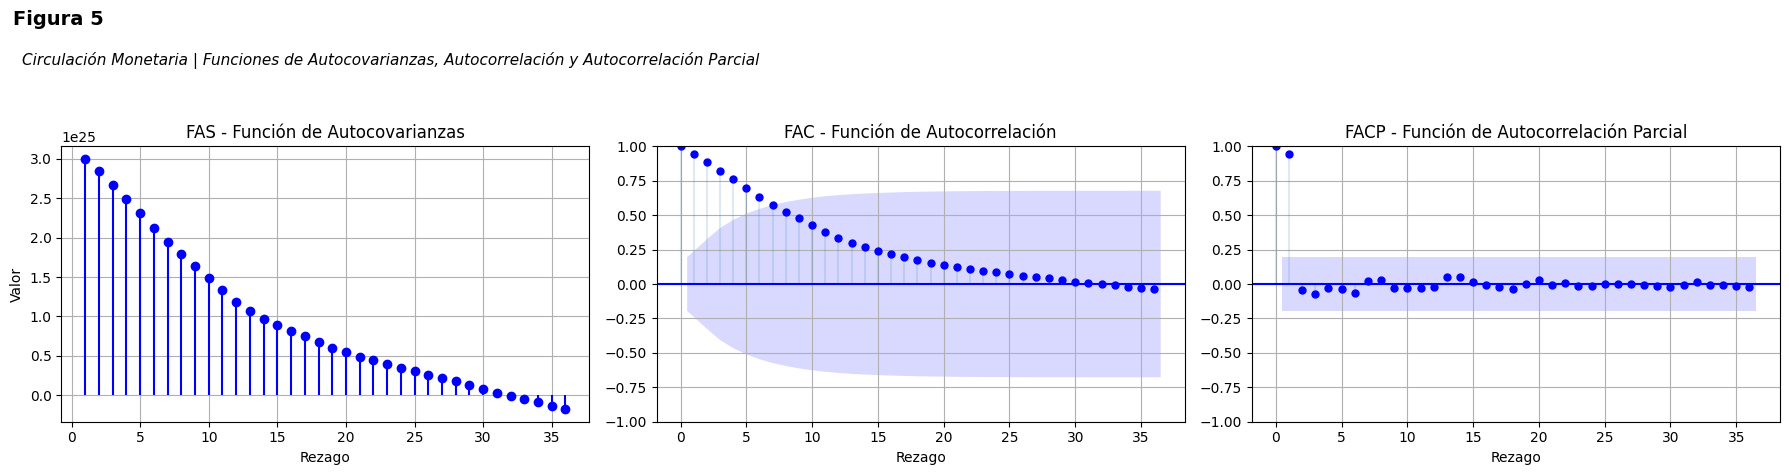

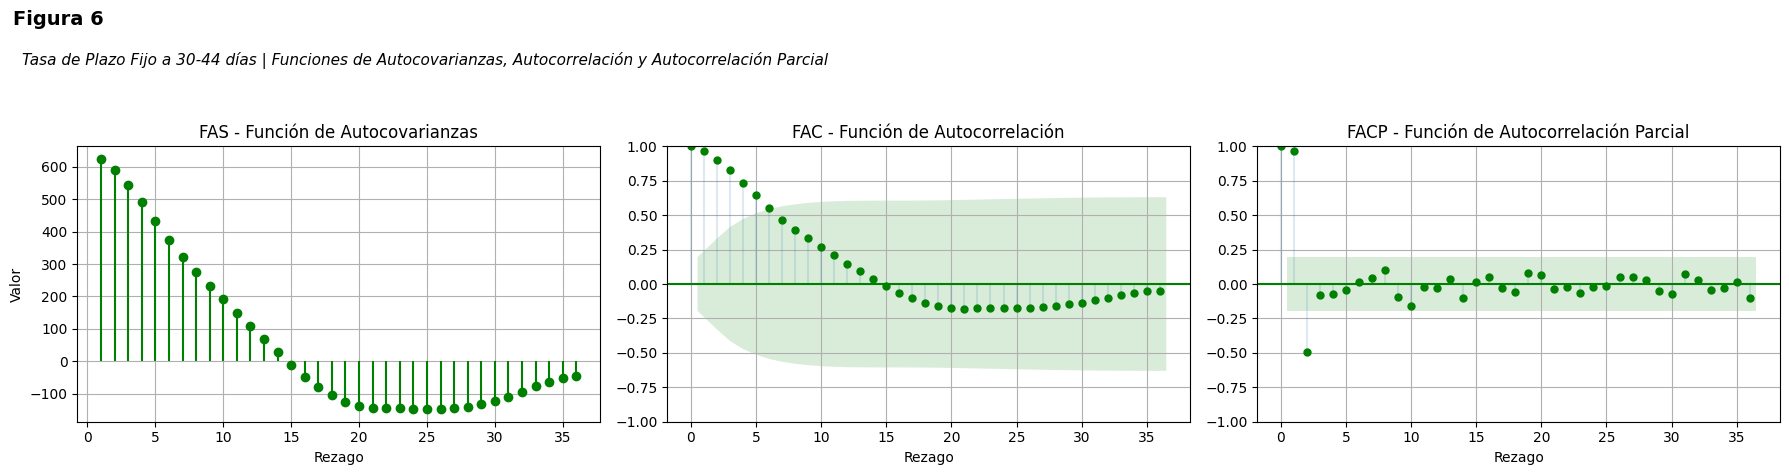

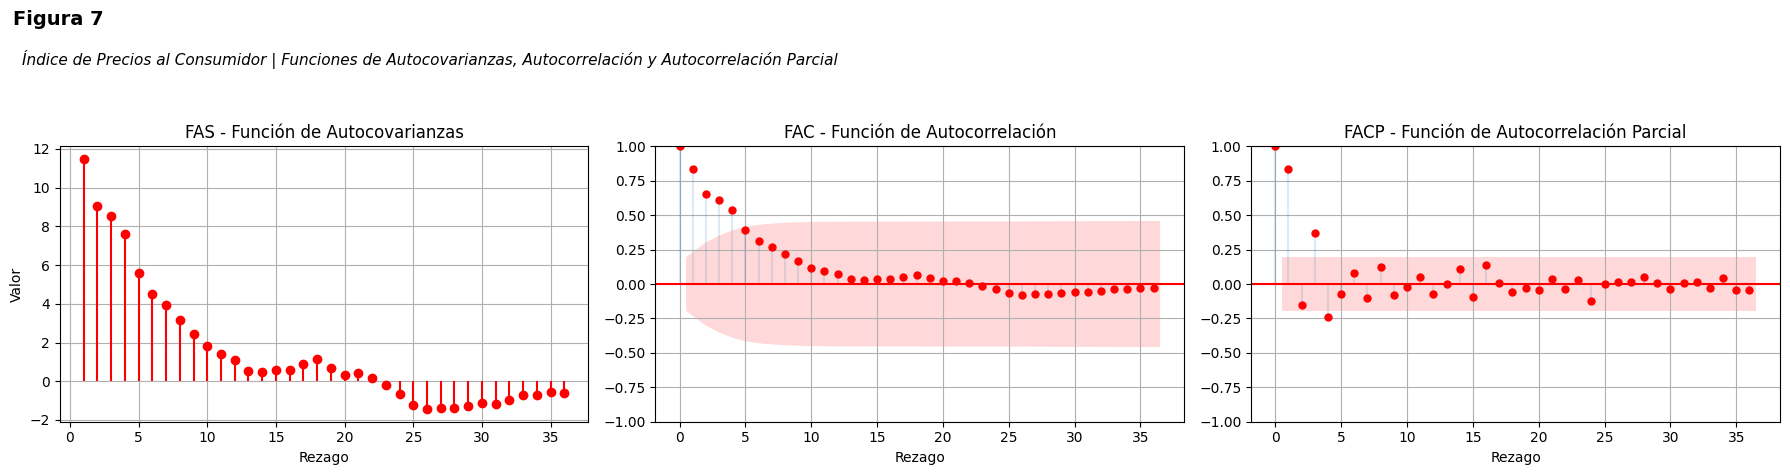

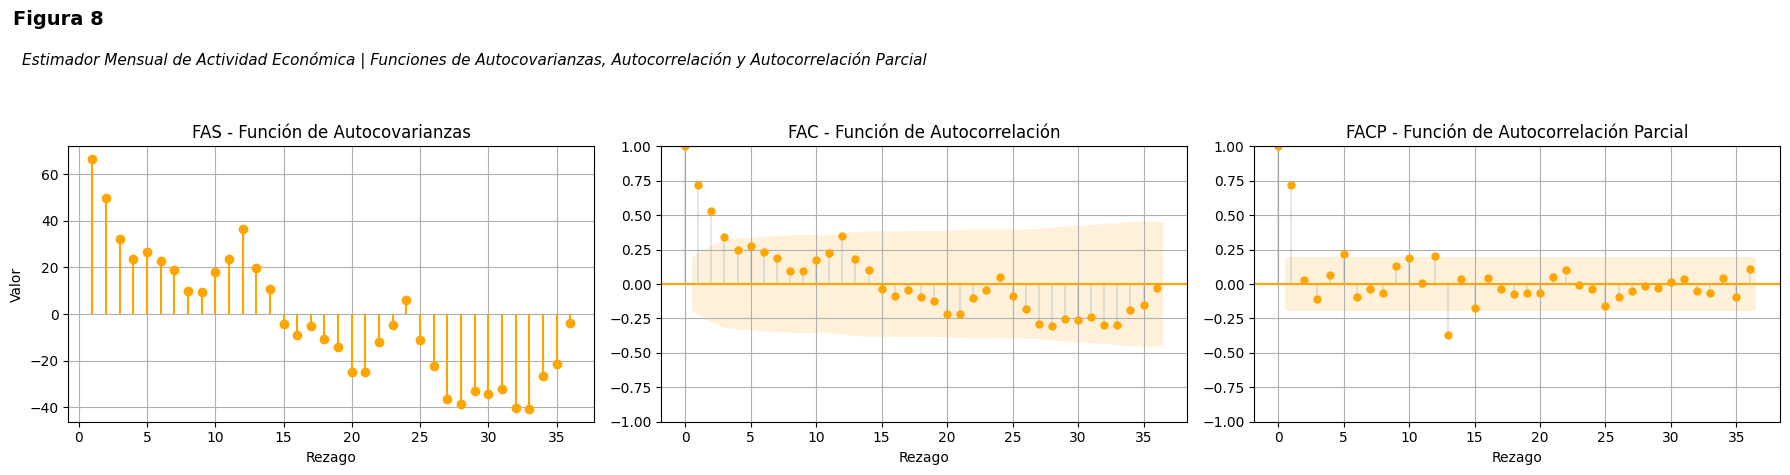

In [ ]:
graficar_fac_fas_facp(
    circulacion_mensual,
    fig_num=5,
    titulo="FAC / FAS / FACP - Circulación Monetaria",
    subtitulo="Circulación Monetaria | Funciones de Autocovarianzas, Autocorrelación y Autocorrelación Parcial",
    color='blue'
)

graficar_fac_fas_facp(
    tasa_pf_mensual,
    fig_num=6,
    titulo="FAC / FAS / FACP - Tasa de Plazo Fijo",
    subtitulo="Tasa de Plazo Fijo a 30-44 días | Funciones de Autocovarianzas, Autocorrelación y Autocorrelación Parcial",
    color='green'
)

graficar_fac_fas_facp(
    ipc_mensual['ipc'],
    fig_num=7,
    titulo="FAC / FAS / FACP - IPC Nacional",
    subtitulo="Índice de Precios al Consumidor | Funciones de Autocovarianzas, Autocorrelación y Autocorrelación Parcial",
    color='red'
)

graficar_fac_fas_facp(
    emae_df['emae'],
    fig_num=8,
    titulo="FAC / FAS / FACP - EMAE",
    subtitulo="Estimador Mensual de Actividad Económica | Funciones de Autocovarianzas, Autocorrelación y Autocorrelación Parcial",
    color='orange'
)

Pruebas de Raíces Unitarias.

In [ ]:
def test_dickey_fuller_simple(serie):
    y = serie.dropna().values
    dy = np.diff(y)
    y_lag = y[:-1]
    X = add_constant(y_lag)
    modelo = OLS(dy, X).fit()
    stat = modelo.tvalues[1]
    crit = {'1%': -3.43, '5%': -2.86, '10%': -2.57}
    conc = 'Estacionaria' if stat < crit['5%'] else 'No Estacionaria'
    return stat, crit, conc

def test_adf(serie):
    resultado = adfuller(serie.dropna(), autolag='AIC')
    stat = resultado[0]
    pval = resultado[1]
    crit = resultado[4]
    conc = 'Estacionaria' if pval < 0.05 else 'No Estacionaria'
    return stat, pval, crit, conc

def test_kpss_test(serie):
    resultado = kpss(serie.dropna(), regression='c', nlags='auto')
    stat = resultado[0]
    pval = resultado[1]
    crit = resultado[3]
    conc = 'Estacionaria' if pval >= 0.05 else 'No Estacionaria'
    return stat, pval, crit, conc

def aplicar_tests_a_series(series_dict, nombre_columna='Variable'):
    resultados = []
    for nombre, serie in series_dict.items():
        df_stat, df_crit, df_conc = test_dickey_fuller_simple(serie)
        adf_stat, adf_p, adf_crit, adf_conc = test_adf(serie)
        kpss_stat, kpss_p, kpss_crit, kpss_conc = test_kpss_test(serie)
        resultados.append({
            nombre_columna: nombre,
            'DF estadístico': round(df_stat, 4),
            'DF 1%': df_crit['1%'], 'DF 5%': df_crit['5%'], 'DF 10%': df_crit['10%'],
            'DF conclusión': df_conc,
            'ADF estadístico': round(adf_stat, 4), 'ADF p-valor': round(adf_p, 4),
            'ADF 1%': adf_crit['1%'], 'ADF 5%': adf_crit['5%'], 'ADF 10%': adf_crit['10%'],
            'ADF conclusión': adf_conc,
            'KPSS estadístico': round(kpss_stat, 4), 'KPSS p-valor': round(kpss_p, 4),
            'KPSS 1%': kpss_crit['1%'], 'KPSS 5%': kpss_crit['5%'], 'KPSS 10%': kpss_crit['10%'],
            'KPSS conclusión': kpss_conc
        })
    return pd.DataFrame(resultados)

def reorganizar_resultados_largo(df_resultados, nombre_columna='Variable'):
    filas = []
    for _, row in df_resultados.iterrows():
        etiqueta = row[nombre_columna]
        for nivel in ['1%', '5%', '10%']:
            filas.append({
                nombre_columna: etiqueta,
                'Significancia': nivel,
                'DF estadístico': row['DF estadístico'],
                'DF crítico': row[f'DF {nivel}'],
                'DF conclusión': row['DF conclusión'],
                'ADF estadístico': row['ADF estadístico'],
                'ADF p-valor': row['ADF p-valor'],
                'ADF crítico': row[f'ADF {nivel}'],
                'ADF conclusión': row['ADF conclusión'],
                'KPSS estadístico': row['KPSS estadístico'],
                'KPSS p-valor': row['KPSS p-valor'],
                'KPSS crítico': row[f'KPSS {nivel}'],
                'KPSS conclusión': row['KPSS conclusión'],
            })
    return pd.DataFrame(filas)

def mostrar_tabla_resultados(df, titulo, nombre_columna='Variable'):
    columnas_numericas = df.select_dtypes(include='number').columns
    estilos = [
        {"selector": "caption", "props": [("caption-side", "top"), ("text-align", "left"), ("font-size", "14px")]},
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ]
    styled = df.style \
        .format({col: "{:.4f}" for col in columnas_numericas}) \
        .set_table_styles(estilos) \
        .set_caption(titulo) \
        .set_properties(**{"text-align": "center"})
    return styled

In [ ]:
series_originales = {
    'Circulación Monetaria': circulacion_mensual,
    'Tasa de Plazo Fijo': tasa_pf_mensual,
    'IPC Nacional': ipc_mensual['ipc'],
    'EMAE': emae_df['emae']
}

tabla1 = aplicar_tests_a_series(series_originales, nombre_columna='Variable')
tabla1_larga = reorganizar_resultados_largo(tabla1, nombre_columna='Variable')
mostrar_tabla_resultados(tabla1_larga, "<b>Tabla 1</b><br><i>Pruebas de raíces unitarias</i>", nombre_columna='Variable')

,Variable,Significancia,DF estadístico,DF crítico,DF conclusión,ADF estadístico,ADF p-valor,ADF crítico,ADF conclusión,KPSS estadístico,KPSS p-valor,KPSS crítico,KPSS conclusión
0,Circulación Monetaria,1%,8.3817,-3.4300,No Estacionaria,2.7310,0.9991,-3.5079,No Estacionaria,1.1952,0.0100,0.7390,No Estacionaria
1,Circulación Monetaria,5%,8.3817,-2.8600,No Estacionaria,2.7310,0.9991,-2.8954,No Estacionaria,1.1952,0.0100,0.4630,No Estacionaria
2,Circulación Monetaria,10%,8.3817,-2.5700,No Estacionaria,2.7310,0.9991,-2.5848,No Estacionaria,1.1952,0.0100,0.3470,No Estacionaria
3,Tasa de Plazo Fijo,1%,-1.3247,-3.4300,No Estacionaria,-2.3915,0.1442,-3.4982,No Estacionaria,0.6137,0.0214,0.7390,No Estacionaria
4,Tasa de Plazo Fijo,5%,-1.3247,-2.8600,No Estacionaria,-2.3915,0.1442,-2.8912,No Estacionaria,0.6137,0.0214,0.4630,No Estacionaria
5,Tasa de Plazo Fijo,10%,-1.3247,-2.5700,No Estacionaria,-2.3915,0.1442,-2.5826,No Estacionaria,0.6137,0.0214,0.3470,No Estacionaria
6,IPC Nacional,1%,-2.9072,-3.4300,Estacionaria,-2.5708,0.0992,-3.4996,No Estacionaria,0.6097,0.0218,0.7390,No Estacionaria
7,IPC Nacional,5%,-2.9072,-2.8600,Estacionaria,-2.5708,0.0992,-2.8918,No Estacionaria,0.6097,0.0218,0.4630,No Estacionaria
8,IPC Nacional,10%,-2.9072,-2.5700,Estacionaria,-2.5708,0.0992,-2.5829,No Estacionaria,0.6097,0.0218,0.3470,No Estacionaria
9,EMAE,1%,-3.7898,-3.4300,Estacionaria,-1.8420,0.3598,-3.5079,No Estacionaria,0.2306,0.1000,0.7390,Estacionaria


Modelos para estimar la variable Circulación Monetaria.

In [ ]:
# Verificación de Estacionalidad mediante test HEGY.
serie = circulacion_mensual

def construir_hegy_vars(x, s=6):
    x_lag1 = x.shift(1)
    signos = np.array([(-1)**t for t in range(len(x))])
    x_lag1_alt = x_lag1 * signos
    x_lag2 = x.shift(2)
    lambdas = [2 * np.pi * j / s for j in [1, 2]]
    Z1 = 2 * np.cos(lambdas[0]) * x_lag1 - x_lag2
    W1 = x_lag1 - 2 * np.cos(lambdas[0]) * x_lag2
    Z2 = 2 * np.cos(lambdas[1]) * x_lag1 - x_lag2
    W2 = x_lag1 - 2 * np.cos(lambdas[1]) * x_lag2

    df_hegy = pd.DataFrame({
        'x_lag1': x_lag1,
        'x_lag1_alt': x_lag1_alt,
        'Z1': Z1,
        'W1': W1,
        'Z2': Z2,
        'W2': W2,
    })

    return df_hegy

hegy_vars = construir_hegy_vars(serie, s=6)

y_diff = serie - serie.shift(6)
df_reg = pd.concat([y_diff, hegy_vars], axis=1).dropna()
Y = df_reg.iloc[:, 0]
X = df_reg.iloc[:, 1:]
X = sm.add_constant(X)

modelo = sm.OLS(Y, X).fit()
print(modelo.summary())

                              OLS Regression Results                             
Dep. Variable:     circulacion_monetaria   R-squared:                       0.931
Model:                               OLS   Adj. R-squared:                  0.929
Method:                    Least Squares   F-statistic:                     410.4
Date:                   Fri, 11 Jul 2025   Prob (F-statistic):           9.71e-53
Time:                           18:10:44   Log-Likelihood:                -2699.5
No. Observations:                     95   AIC:                             5407.
Df Residuals:                         91   BIC:                             5417.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.171e+11 

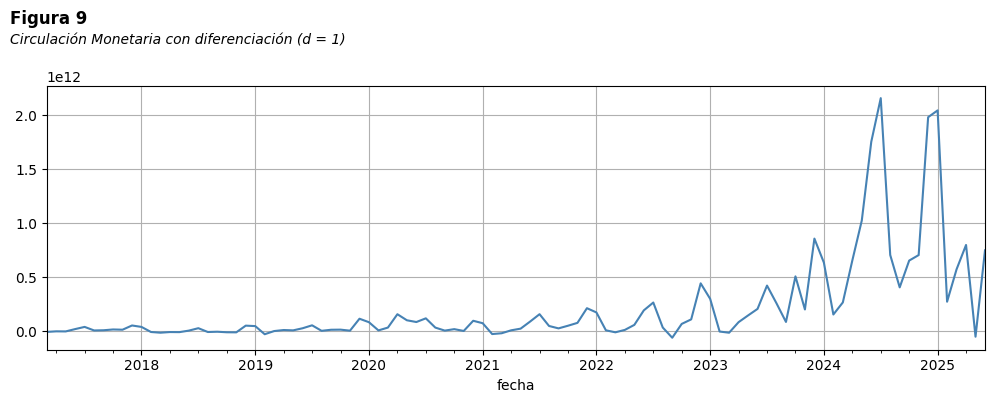

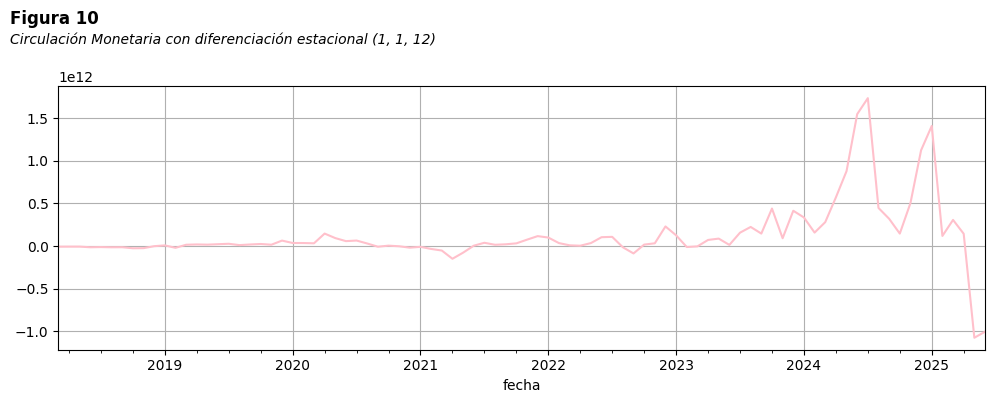

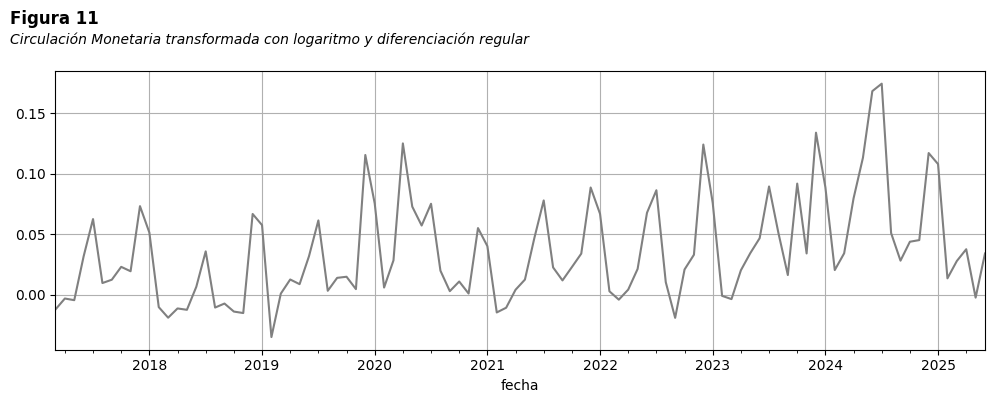

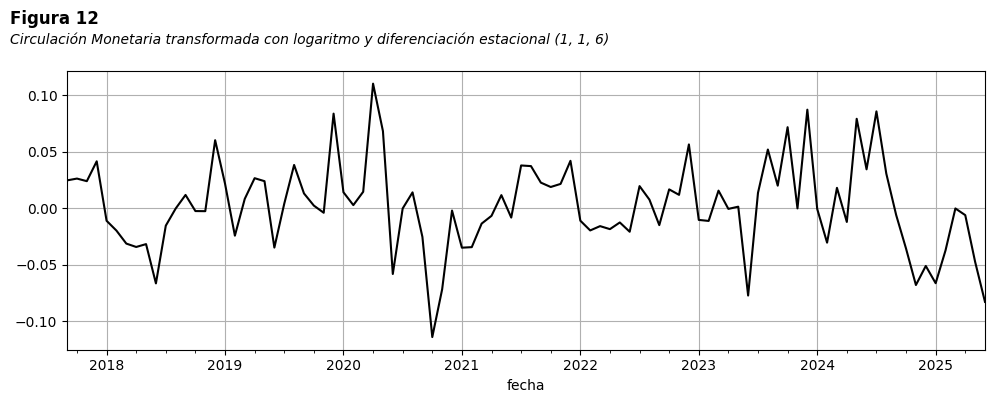

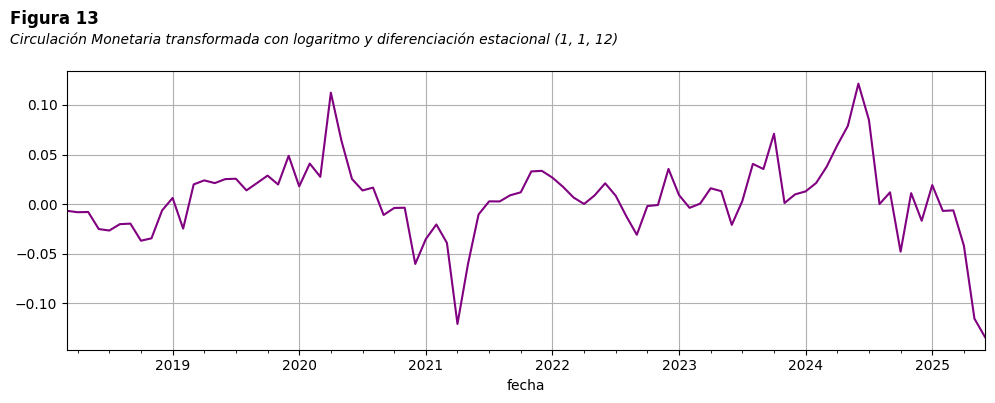

In [ ]:
# Transformaciones propuestas:
# Diferenciación regular y estacional.
serie_diff = serie.diff().dropna()
serie_diff_seasonal = serie_diff.diff(12).dropna()

fig, ax = plt.subplots(figsize=(10, 4))
serie_diff.plot(ax=ax, color='steelblue')
ax.grid(True)
fig.text(0.01, 0.96, "Figura 9", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Circulación Monetaria con diferenciación (d = 1)", fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
serie_diff_seasonal.plot(ax=ax, color='pink')
ax.grid(True)
fig.text(0.01, 0.96, "Figura 10", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Circulación Monetaria con diferenciación estacional (1, 1, 12)", fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

# Transformación logarítmica.
serie_log = np.log(serie)

# Diferencias regular y estacional después de la transformación logarítmica.
serie_log_diff1 = serie_log.diff().dropna()
serie_log_diff_seasonal_6 = serie_log_diff1.diff(6).dropna()
serie_log_diff_seasonal = serie_log_diff1.diff(12).dropna()

fig, ax = plt.subplots(figsize=(10, 4))
serie_log_diff1.plot(ax=ax, color='gray')
ax.grid(True)
fig.text(0.01, 0.96, "Figura 11", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Circulación Monetaria transformada con logaritmo y diferenciación regular", fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
serie_log_diff_seasonal_6.plot(ax=ax, color='black')
ax.grid(True)
fig.text(0.01, 0.96, "Figura 12", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Circulación Monetaria transformada con logaritmo y diferenciación estacional (1, 1, 6)", fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
serie_log_diff_seasonal.plot(ax=ax, color='purple')
ax.grid(True)
fig.text(0.01, 0.96, "Figura 13", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Circulación Monetaria transformada con logaritmo y diferenciación estacional (1, 1, 12)", fontsize=10, style='italic', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()

In [ ]:
series_transformadas = {
    'Diferenciación Regular (d=1)': serie_diff,
    'Diferenciación Estacional (1, 1, 12)': serie_diff_seasonal,
    'Log + Diferenciación Regular': serie_log_diff1,
    'Log + Diferenciación Estacional (1, 1, 6)': serie_log_diff_seasonal_6,
    'Log + Diferenciación Estacional (1, 1, 12)': serie_log_diff_seasonal
}

tabla2 = aplicar_tests_a_series(series_transformadas, nombre_columna='Transformación')
tabla2_larga = reorganizar_resultados_largo(tabla2, nombre_columna='Transformación')
mostrar_tabla_resultados(tabla2_larga, "<b>Tabla 2</b><br><i>Tests de raíces unitarias para series transformadas</i>", nombre_columna='Transformación')

,Transformación,Significancia,DF estadístico,DF crítico,DF conclusión,ADF estadístico,ADF p-valor,ADF crítico,ADF conclusión,KPSS estadístico,KPSS p-valor,KPSS crítico,KPSS conclusión
0,Diferenciación Regular (d=1),1%,-4.1064,-3.4300,Estacionaria,-5.6720,0.0000,-3.5079,Estacionaria,1.0296,0.0100,0.7390,No Estacionaria
1,Diferenciación Regular (d=1),5%,-4.1064,-2.8600,Estacionaria,-5.6720,0.0000,-2.8954,Estacionaria,1.0296,0.0100,0.4630,No Estacionaria
2,Diferenciación Regular (d=1),10%,-4.1064,-2.5700,Estacionaria,-5.6720,0.0000,-2.5848,Estacionaria,1.0296,0.0100,0.3470,No Estacionaria
3,"Diferenciación Estacional (1, 1, 12)",1%,-3.1004,-3.4300,Estacionaria,-4.8749,0.0000,-3.5183,Estacionaria,0.4941,0.0430,0.7390,No Estacionaria
4,"Diferenciación Estacional (1, 1, 12)",5%,-3.1004,-2.8600,Estacionaria,-4.8749,0.0000,-2.8999,Estacionaria,0.4941,0.0430,0.4630,No Estacionaria
5,"Diferenciación Estacional (1, 1, 12)",10%,-3.1004,-2.5700,Estacionaria,-4.8749,0.0000,-2.5872,Estacionaria,0.4941,0.0430,0.3470,No Estacionaria
6,Log + Diferenciación Regular,1%,-6.0191,-3.4300,Estacionaria,-2.5167,0.1115,-3.5079,No Estacionaria,0.9319,0.0100,0.7390,No Estacionaria
7,Log + Diferenciación Regular,5%,-6.0191,-2.8600,Estacionaria,-2.5167,0.1115,-2.8954,No Estacionaria,0.9319,0.0100,0.4630,No Estacionaria
8,Log + Diferenciación Regular,10%,-6.0191,-2.5700,Estacionaria,-2.5167,0.1115,-2.5848,No Estacionaria,0.9319,0.0100,0.3470,No Estacionaria
9,"Log + Diferenciación Estacional (1, 1, 6)",1%,-6.0357,-3.4300,Estacionaria,-3.5667,0.0064,-3.5127,Estacionaria,0.0778,0.1000,0.7390,Estacionaria


Estimación de los coeficientes de los modelos y análisis de diagnóstico de los residuos.

In [ ]:
# Modelo con transformación logarítmica y diferenciación estacional de 6 meses. Separación de datos de entrenamiento.
# Meses de prueba: últimos 12. Meses de entrenamiento: Todos los anteriores.
n_test_6 = 12
train_6 = serie_log_diff_seasonal_6.iloc[:-n_test_6]
test_6 = serie_log_diff_seasonal_6.iloc[-n_test_6:]

In [ ]:
# Modelo SARIMA con estacionalidad de 6 meses sobre la serie logarítmica con diferenciación estacional de 6 meses.
modelo1 = sm.tsa.SARIMAX(
    train_6,
    order=(0, 1, 1),
    seasonal_order=(1, 1, 1, 6),
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultado_6 = modelo1.fit(disp=False)
resid_6 = resultado_6.resid
resid_std_6 = (resid_6 - resid_6.mean()) / resid_6.std()
print(resultado_6.summary())

                                     SARIMAX Results                                     
Dep. Variable:             circulacion_monetaria   No. Observations:                   82
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                 141.028
Date:                           Fri, 11 Jul 2025   AIC                           -274.056
Time:                                   18:10:46   BIC                           -265.237
Sample:                               09-01-2017   HQIC                          -270.566
                                    - 06-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3559      0.129     -2.763      0.006      -0.608      -0.103
ar.S.L6       -0.8249      0.060    -13.737

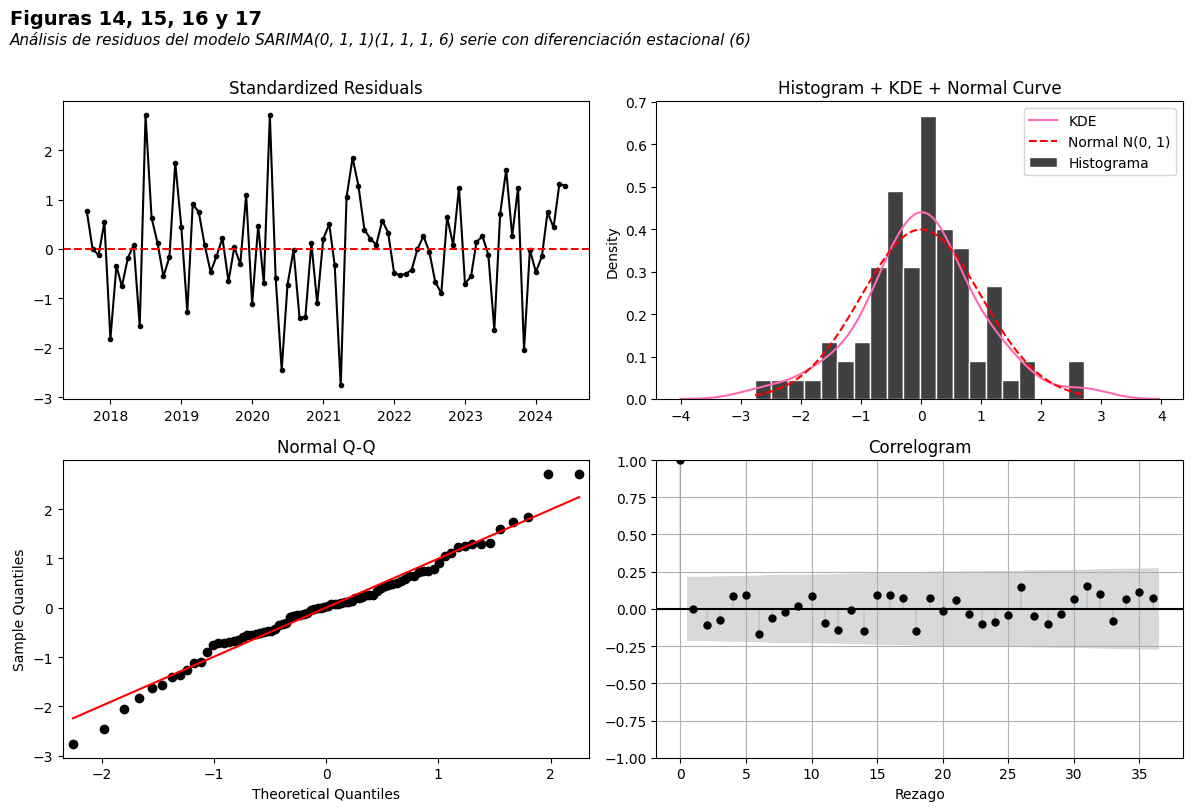

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Standardized Residuals
axes[0, 0].plot(resid_std_6, color='black', marker='o', markersize=3)
axes[0, 0].axhline(y=0, linestyle='--', color='red')
axes[0, 0].set_title("Standardized Residuals", color='black')
axes[0, 0].tick_params(colors='black')

# Histogram
sns.histplot(
    resid_std_6,
    bins=20,
    kde=False,
    color='black',
    edgecolor='white',
    stat="density",
    ax=axes[0, 1],
    label='Histograma'
)
sns.kdeplot(
    resid_std_6,
    color='hotpink',
    ax=axes[0, 1],
    label='KDE'
)
x = np.linspace(resid_std_6.min(), resid_std_6.max(), 100)
axes[0, 1].plot(
    x,
    norm.pdf(x, 0, 1),
    color='red',
    linestyle='--',
    label='Normal N(0, 1)'
)
axes[0, 1].set_title("Histogram + KDE + Normal Curve", color='black')
axes[0, 1].legend()
axes[0, 1].tick_params(colors='black')

# Q-Q Plot
qq = qqplot(resid_std_6, line='s', ax=axes[1, 0])
if axes[1, 0].collections:
    dots = axes[1, 0].collections[0]
    dots.set_facecolor('black')
    dots.set_edgecolor('black')
elif len(axes[1, 0].lines) > 1:
    puntos = axes[1, 0].lines[0]
    puntos.set_color('black')
    puntos.set_markerfacecolor('black')
    puntos.set_markeredgecolor('black')
if len(axes[1, 0].lines) > 1:
    linea_teorica = axes[1, 0].lines[1]
    linea_teorica.set_color('red')
axes[1, 0].set_title("Normal Q-Q", color='black')
axes[1, 0].tick_params(colors='black')

# Correlograma
color = 'black'
max_lags = 36
plot_acf(resid_std_6, ax=axes[1, 1], lags=max_lags, alpha=0.05, color=color)
axes[1, 1].set_title('Correlogram', fontsize=12, color=color)
axes[1, 1].set_xlabel('Rezago')
axes[1, 1].grid(True)
for line in axes[1, 1].lines:
    line.set_color(color)
    line.set_markerfacecolor(color)
    line.set_markeredgecolor(color)
for patch in axes[1, 1].collections:
    patch.set_facecolor(color)
    patch.set_alpha(0.15)
axes[1, 1].tick_params(colors=color)

fig.text(0.01, 0.99, "Figuras 14, 15, 16 y 17", fontsize=14, fontweight='bold', color='black', ha='left')
fig.text(0.01, 0.965, "Análisis de residuos del modelo SARIMA(0, 1, 1)(1, 1, 1, 6) serie con diferenciación estacional (6)", fontsize=11, style='italic', color='black', ha='left')
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

In [ ]:
# Modelo con transformación logarítmica y diferenciación estacional de 12 meses. Separación de datos de entrenamiento.
# Meses de prueba: últimos 12. Meses de entrenamiento: Todos los anteriores.
n_test_12 = 12
train_12 = serie_log_diff_seasonal.iloc[:-n_test_12]
test_12 = serie_log_diff_seasonal.iloc[-n_test_12:]

In [ ]:
# Modelo SARIMA con estacionalidad de 12 meses sobre la serie logarítmica con diferenciación estacional de 6 meses.
modelo2 = sm.tsa.SARIMAX(
    train_12,
    order=(0, 1, 1),
    seasonal_order=(0, 1, 1, 6),
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultado_12 = modelo2.fit(disp=False)
resid_12 = resultado_12.resid
resid_std_12 = (resid_12 - resid_12.mean()) / resid_12.std()
print(resultado_12.summary())

                                     SARIMAX Results                                     
Dep. Variable:             circulacion_monetaria   No. Observations:                   76
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 6)   Log Likelihood                 126.361
Date:                           Fri, 11 Jul 2025   AIC                           -246.723
Time:                                   18:10:48   BIC                           -240.390
Sample:                               03-01-2018   HQIC                          -244.241
                                    - 06-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2880      0.129     -2.237      0.025      -0.540      -0.036
ma.S.L6       -1.0001    269.357     -0.004

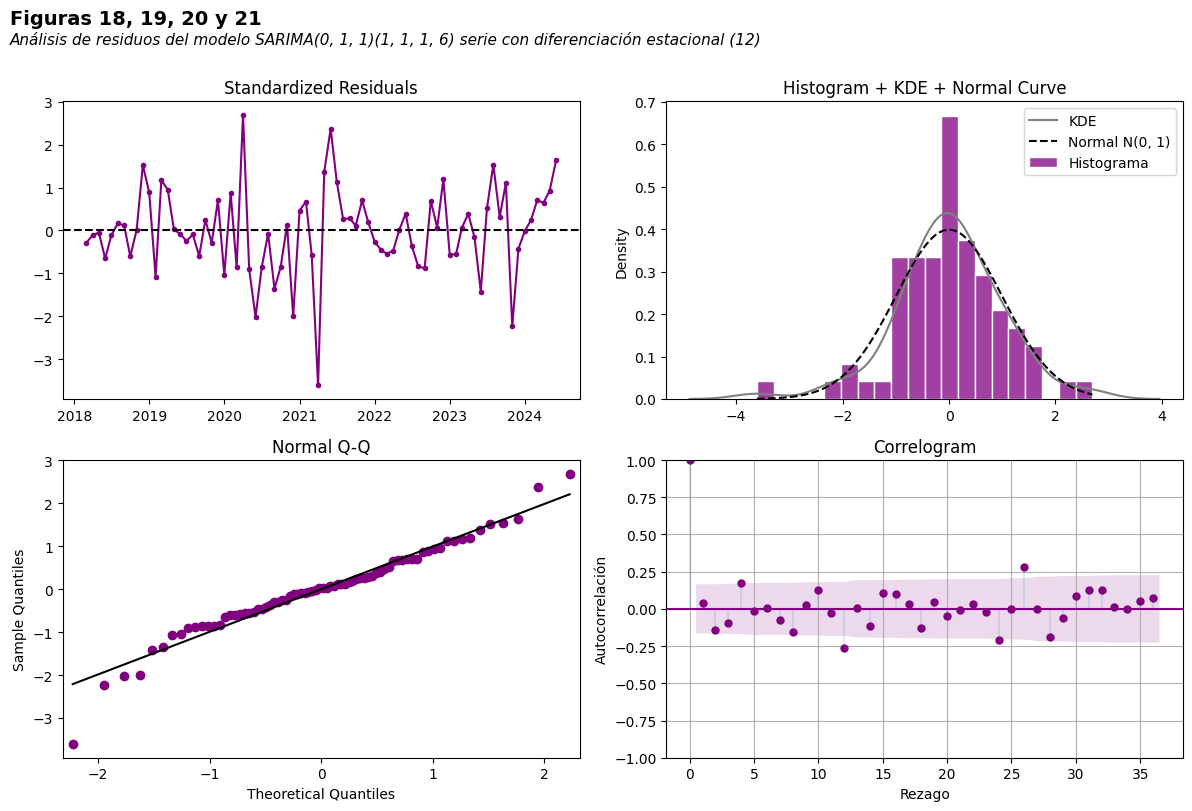

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Standardized Residuals
axes[0, 0].plot(resid_std_12, color='purple', marker='o', markersize=3)
axes[0, 0].axhline(y=0, linestyle='--', color='black')
axes[0, 0].set_title("Standardized Residuals", color='black')
axes[0, 0].tick_params(colors='black')

# Histogram
sns.histplot(
    resid_std_12,
    bins=20,
    kde=False,
    color='purple',
    edgecolor='white',
    stat="density",
    ax=axes[0, 1],
    label='Histograma'
)
sns.kdeplot(
    resid_std_12,
    color='gray',
    ax=axes[0, 1],
    label='KDE'
)
x = np.linspace(resid_std_12.min(), resid_std_12.max(), 100)
axes[0, 1].plot(
    x,
    norm.pdf(x, 0, 1),
    color='black',
    linestyle='--',
    label='Normal N(0, 1)'
)
axes[0, 1].set_title("Histogram + KDE + Normal Curve", color='black')
axes[0, 1].legend()
axes[0, 1].tick_params(colors='black')

# Q-Q Plot
qq = qqplot(resid_std_12, line='s', ax=axes[1, 0])
if axes[1, 0].collections:
    dots = axes[1, 0].collections[0]
    dots.set_facecolor('purple')
    dots.set_edgecolor('purple')
elif len(axes[1, 0].lines) > 1:
    puntos = axes[1, 0].lines[0]
    puntos.set_color('purple')
    puntos.set_markerfacecolor('purple')
    puntos.set_markeredgecolor('purple')
if len(axes[1, 0].lines) > 1:
    linea_teorica = axes[1, 0].lines[1]
    linea_teorica.set_color('black')
axes[1, 0].set_title("Normal Q-Q", color='black')
axes[1, 0].tick_params(colors='black')

# Correlograma
color_lineas = 'purple'
color_textos = 'black'
max_lags = 36
plot_acf(resid_std_12, ax=axes[1, 1], lags=max_lags, alpha=0.15, color=color_lineas, title='')
axes[1, 1].set_title('Correlogram', fontsize=12, color=color_textos)
axes[1, 1].set_xlabel('Rezago', color=color_textos)
axes[1, 1].set_ylabel('Autocorrelación', color=color_textos)
axes[1, 1].grid(True)

for line in axes[1, 1].lines:
    line.set_color(color_lineas)
    line.set_markerfacecolor(color_lineas)
    line.set_markeredgecolor(color_lineas)
for patch in axes[1, 1].collections:
    patch.set_facecolor(color_lineas)
    patch.set_alpha(0.15)
axes[1, 1].tick_params(colors=color_textos)

fig.text(0.01, 0.99, "Figuras 18, 19, 20 y 21", fontsize=14, fontweight='bold', color='black', ha='left')
fig.text(0.01, 0.965, "Análisis de residuos del modelo SARIMA(0, 1, 1)(1, 1, 1, 6) serie con diferenciación estacional (12)", fontsize=11, style='italic', color='black', ha='left')

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

Pronóstico a partir del modelo seleccionado y comparación con otros modelos.

In [ ]:
# Modelo SARIMA(0, 1, 1)(1, 1, 1, 6) serie con diferenciación estacional (6).
pred_6 = resultado_6.get_forecast(steps=n_test_6)
pred_mean_log_6 = pred_6.predicted_mean
pred_ci_log_6 = pred_6.conf_int()

pred_mean_6 = np.exp(pred_mean_log_6)
pred_ci_6 = np.exp(pred_ci_log_6)
test_original_6 = np.exp(test_6)

rmse_6 = np.sqrt(mean_squared_error(test_original_6, pred_mean_6))
mae_6 = mean_absolute_error(test_original_6, pred_mean_6)
mape_6 = np.mean(np.abs((test_original_6 - pred_mean_6) / test_original_6)) * 100

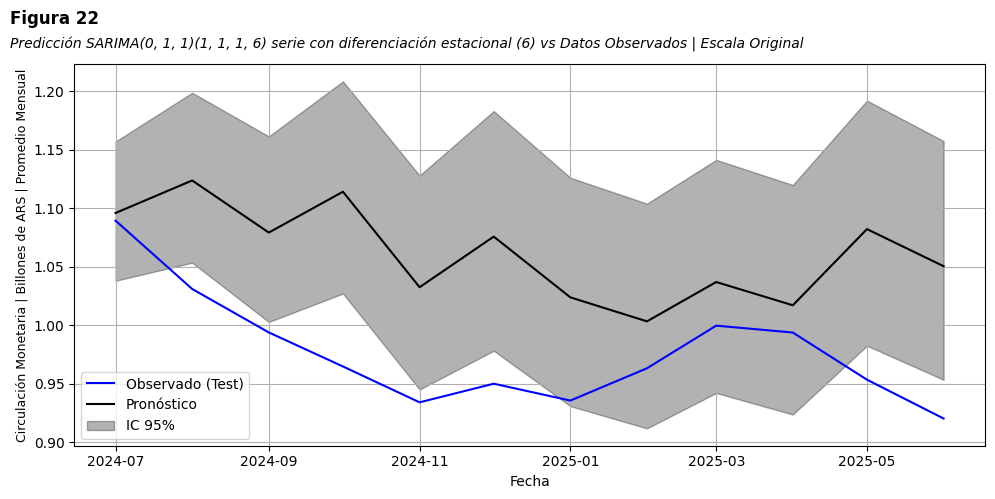

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(test_original_6.index, test_original_6, label='Observado (Test)', color='blue')
plt.plot(test_original_6.index, pred_mean_6, label='Pronóstico', color='black')
plt.fill_between(test_original_6.index, pred_ci_6.iloc[:, 0], pred_ci_6.iloc[:, 1],
                 color='black', alpha=0.3, label='IC 95%')
fig.text(0.01, 0.96, "Figura 22", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Predicción SARIMA(0, 1, 1)(1, 1, 1, 6) serie con diferenciación estacional (6) vs Datos Observados | Escala Original", fontsize=10, style='italic', ha='left')
plt.xlabel("Fecha")
plt.ylabel("Circulación Monetaria | Billones de ARS | Promedio Mensual", fontsize=9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [ ]:
# Modelo SARIMA(0, 1, 1)(0, 1, 1, 6) serie con diferenciación estacional (12).
pred_12 = resultado_12.get_forecast(steps=n_test_12)
pred_mean_log_12 = pred_12.predicted_mean
pred_ci_log_12 = pred_12.conf_int()

pred_mean_12 = np.exp(pred_mean_log_12)
pred_ci_12 = np.exp(pred_ci_log_12)
test_original_12 = np.exp(test_12)

rmse_12 = np.sqrt(mean_squared_error(test_original_12, pred_mean_12))
mae_12 = mean_absolute_error(test_original_12, pred_mean_12)
mape_12 = np.mean(np.abs((test_original_12 - pred_mean_12) / test_original_12)) * 100

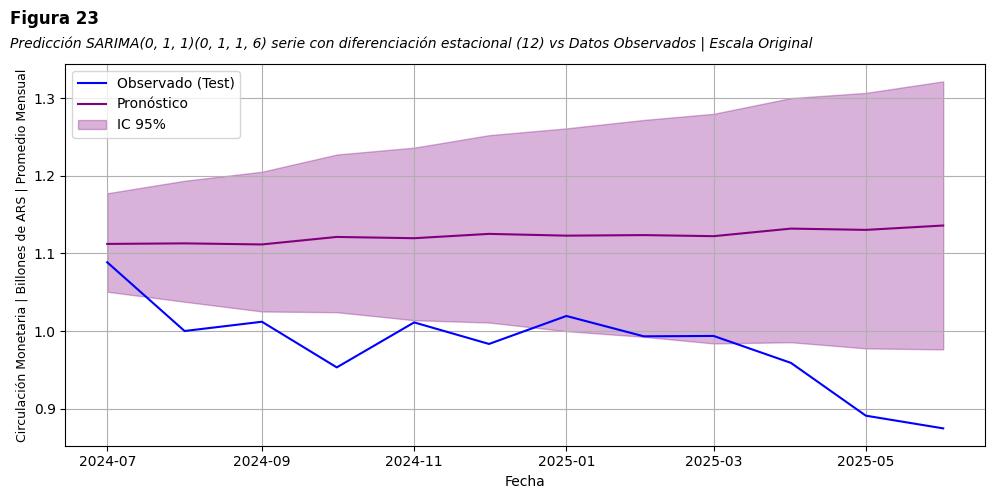

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.plot(test_original_12.index, test_original_12, label='Observado (Test)', color='blue')
plt.plot(test_original_12.index, pred_mean_12, label='Pronóstico', color='purple')
plt.fill_between(test_original_12.index, pred_ci_12.iloc[:, 0], pred_ci_12.iloc[:, 1],
                 color='purple', alpha=0.3, label='IC 95%')
fig.text(0.01, 0.96, "Figura 23", fontsize=12, fontweight='bold', ha='left')
fig.text(0.01, 0.91, "Predicción SARIMA(0, 1, 1)(0, 1, 1, 6) serie con diferenciación estacional (12) vs Datos Observados | Escala Original", fontsize=10, style='italic', ha='left')
plt.xlabel("Fecha")
plt.ylabel("Circulación Monetaria | Billones de ARS | Promedio Mensual", fontsize=9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In [ ]:
resultados_modelos = pd.DataFrame([
    {
        "Modelo": "SARIMA(0,1,1)(1,1,1,6)",
        "Estacionalidad de la Serie": "6 meses",
        "RMSE": round(rmse_6, 4),
        "MAE": round(mae_6, 4),
        "MAPE (%)": round(mape_6, 2)
    },
    {
        "Modelo": "SARIMA(0,1,1)(0,1,1,6)",
        "Estacionalidad de la Serie": "12 meses",
        "RMSE": round(rmse_12, 4),
        "MAE": round(mae_12, 4),
        "MAPE (%)": round(mape_12, 2)
    }
])

mostrar_tabla_resultados(
    resultados_modelos,
    "<b>Tabla 3</b><br><i>Comparación de desempeño de modelos SARIMA</i>",
    nombre_columna="Modelo"
)

,Modelo,Estacionalidad de la Serie,RMSE,MAE,MAPE (%)
0,"SARIMA(0,1,1)(1,1,1,6)",6 meses,0.0951,0.0838,8.7200
1,"SARIMA(0,1,1)(0,1,1,6)",12 meses,0.1538,0.1410,14.7700


Modelo SARIMA-X

In [ ]:
# Transformaciones necesarias para contar con todas las variables para el modelo.
y = serie_log_diff_seasonal_6
log_tasa = np.log(tasa_pf_mensual)
log_ipc = np.log(ipc_mensual['ipc'])
log_emae = np.log(emae_df['emae'])

log_tasa_diff1 = log_tasa.diff().dropna()
log_ipc_diff1 = log_ipc.diff().dropna()
log_emae_diff1 = log_emae.diff().dropna()
log_tasa_diff_seasonal_6 = log_tasa_diff1.diff(6).dropna()
log_ipc_diff_seasonal_6 = log_ipc_diff1.diff(6).dropna()
log_emae_diff_seasonal_6 = log_emae_diff1.diff(6).dropna()

X = pd.concat([
    log_tasa_diff_seasonal_6,
    log_ipc_diff_seasonal_6,
    log_emae_diff_seasonal_6
], axis=1)
X.columns = ['tasa_pf', 'ipc', 'emae']
y, X = y.align(X, join='inner')

In [ ]:
# Separación de datos en entrenamiento y prueba.
n_test = 12
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]
X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]

In [ ]:
# Aplicación del modelo.
modelo_sarimax = sm.tsa.SARIMAX(
    y_train,
    exog=X_train,
    order=(0, 1, 1),
    seasonal_order=(1, 1, 1, 6),
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultado_sarimax = modelo_sarimax.fit(disp=False)
resid_sarimax = resultado_sarimax.resid
resid_std_sarimax = (resid_sarimax - resid_sarimax.mean()) / resid_sarimax.std()
print(resultado_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:             circulacion_monetaria   No. Observations:                   82
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                 144.385
Date:                           Fri, 11 Jul 2025   AIC                           -274.770
Time:                                   18:10:50   BIC                           -259.337
Sample:                               09-01-2017   HQIC                          -268.663
                                    - 06-01-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tasa_pf       -0.0274      0.021     -1.303      0.193      -0.069       0.014
ipc           -0.0069      0.006     -1.096

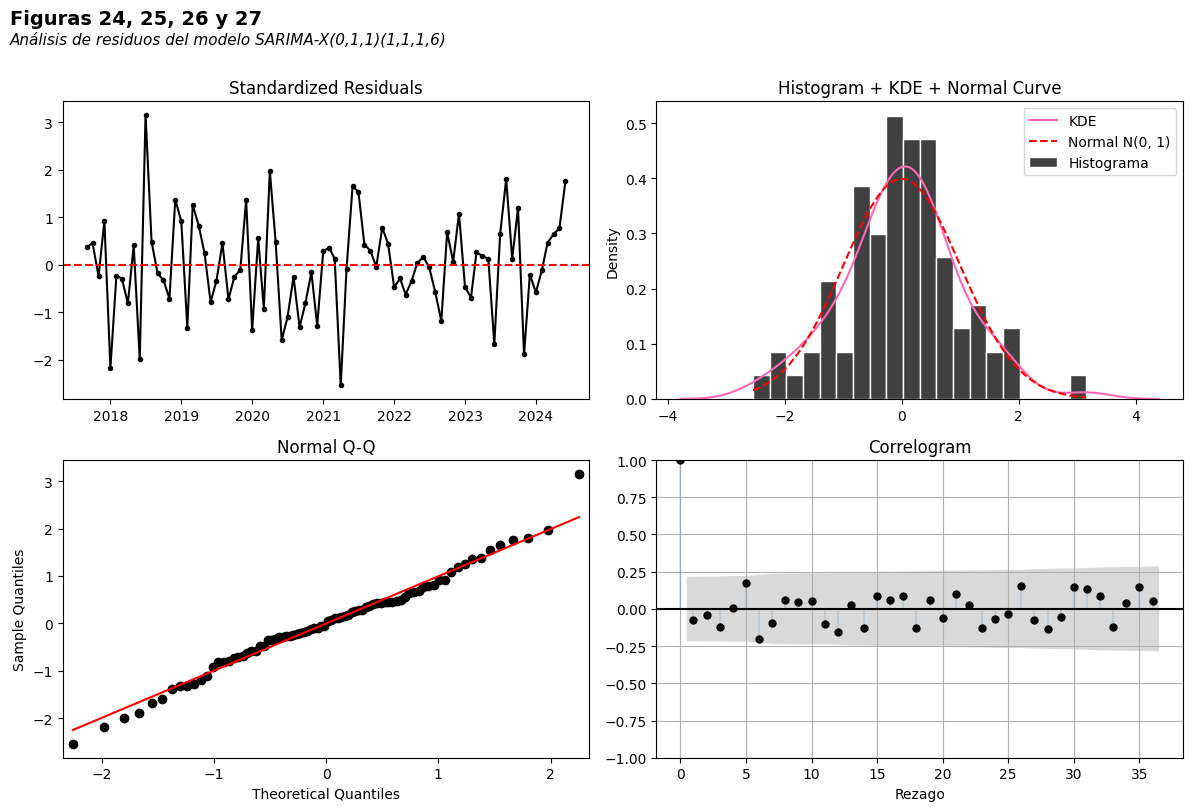

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residuales estandarizados
axes[0, 0].plot(resid_std_sarimax, color='black', marker='o', markersize=3)
axes[0, 0].axhline(y=0, linestyle='--', color='red')
axes[0, 0].set_title("Standardized Residuals", color='black')
axes[0, 0].tick_params(colors='black')

# Histograma + KDE + Curva Normal
sns.histplot(
    resid_std_sarimax,
    bins=20,
    kde=False,
    color='black',
    edgecolor='white',
    stat="density",
    ax=axes[0, 1],
    label='Histograma'
)
sns.kdeplot(
    resid_std_sarimax,
    color='hotpink',
    ax=axes[0, 1],
    label='KDE'
)
x = np.linspace(resid_std_sarimax.min(), resid_std_sarimax.max(), 100)
axes[0, 1].plot(x, norm.pdf(x, 0, 1), color='red', linestyle='--', label='Normal N(0, 1)')
axes[0, 1].set_title("Histogram + KDE + Normal Curve", color='black')
axes[0, 1].legend()
axes[0, 1].tick_params(colors='black')

# Q-Q plot
qq = qqplot(resid_std_sarimax, line='s', ax=axes[1, 0])
if axes[1, 0].collections:
    dots = axes[1, 0].collections[0]
    dots.set_facecolor('black')
    dots.set_edgecolor('black')
elif len(axes[1, 0].lines) > 1:
    puntos = axes[1, 0].lines[0]
    puntos.set_color('black')
    puntos.set_markerfacecolor('black')
    puntos.set_markeredgecolor('black')
if len(axes[1, 0].lines) > 1:
    linea_teorica = axes[1, 0].lines[1]
    linea_teorica.set_color('red')
axes[1, 0].set_title("Normal Q-Q", color='black')
axes[1, 0].tick_params(colors='black')

# Correlograma
color = 'black'
plot_acf(resid_std_sarimax, ax=axes[1, 1], lags=36, alpha=0.05, color=color)
axes[1, 1].set_title('Correlogram', fontsize=12, color=color)
axes[1, 1].set_xlabel('Rezago')
axes[1, 1].grid(True)
for line in axes[1, 1].lines:
    line.set_color(color)
    line.set_markerfacecolor(color)
    line.set_markeredgecolor(color)
for patch in axes[1, 1].collections:
    patch.set_facecolor(color)
    patch.set_alpha(0.15)
axes[1, 1].tick_params(colors=color)

fig.text(0.01, 0.99, "Figuras 24, 25, 26 y 27", fontsize=14, fontweight='bold', color='black', ha='left')
fig.text(0.01, 0.965, "Análisis de residuos del modelo SARIMA-X(0, 1, 1)(1, 1, 1, 6) serie con diferenciación estacional (6) y variables regresoras", fontsize=11, style='italic', color='black', ha='left')

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

In [ ]:
X_test = X_test.replace([np.inf, -np.inf], np.nan).dropna()
y_test = y_test.loc[X_test.index]

# Predicción
forecast = resultado_sarimax.get_forecast(steps=len(X_test), exog=X_test)
y_pred_diff_log = forecast.predicted_mean
y_ci_diff_log = forecast.conf_int()

log_y_t_minus_6 = np.log(circulacion_mensual.shift(6).loc[y_pred_diff_log.index])
log_y_pred = y_pred_diff_log + log_y_t_minus_6
y_pred_original = np.exp(log_y_pred)
y_real_original = circulacion_mensual.loc[y_pred_diff_log.index]

# Métricas de error en escala original
rmse = np.sqrt(mean_squared_error(y_real_original, y_pred_original))
mae = mean_absolute_error(y_real_original, y_pred_original)
mape = np.mean(np.abs((y_real_original - y_pred_original) / y_real_original)) * 100

print(f"📉 RMSE SARIMA-X (original): ${rmse:,.0f}")
print(f"📉 MAE  SARIMA-X (original): ${mae:,.0f}")
print(f"📉 MAPE SARIMA-X (original): {mape:.2f}%")

📉 RMSE SARIMA-X (original): $5,964,634,402,437
📉 MAE  SARIMA-X (original): $5,957,959,764,242
📉 MAPE SARIMA-X (original): 35.03%


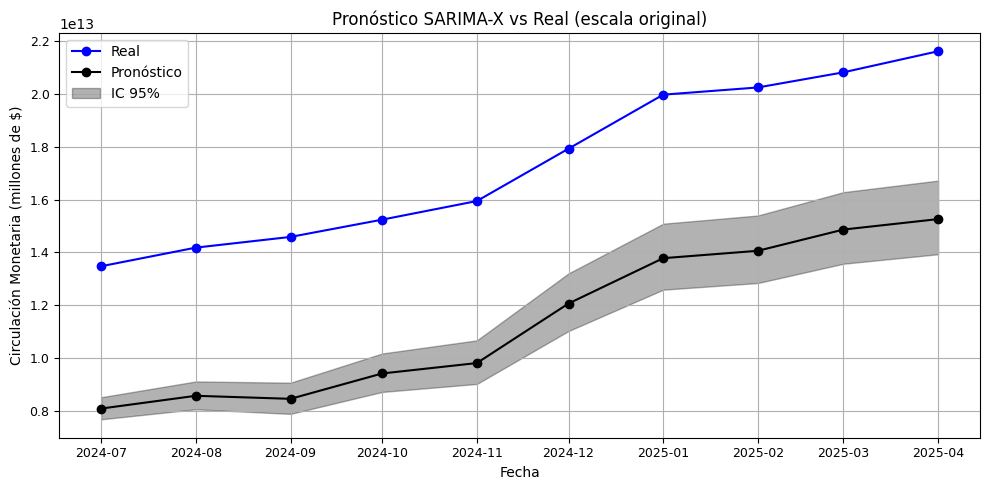


📊 Tabla de valores reales vs pronosticados (escala original):

       Fecha     Valor real ($)     Pronóstico ($)    Error absoluto  \
0 2024-07-01 13,474,926,136,364  8,091,786,389,960 5,383,139,746,403   
1 2024-08-01 14,179,582,590,909  8,574,681,054,004 5,604,901,536,905   
2 2024-09-01 14,584,730,761,905  8,459,777,752,200 6,124,953,009,705   
3 2024-10-01 15,237,919,181,818  9,419,412,592,825 5,818,506,588,993   
4 2024-11-01 15,941,969,473,684  9,812,772,955,845 6,129,196,517,840   
5 2024-12-01 17,922,331,052,632 12,065,163,427,828 5,857,167,624,803   
6 2025-01-01 19,965,758,363,636 13,780,282,291,345 6,185,476,072,291   
7 2025-02-01 20,238,349,750,000 14,059,694,654,589 6,178,655,095,411   
8 2025-03-01 20,810,763,833,333 14,862,706,977,169 5,948,056,856,164   
9 2025-04-01 21,608,463,894,737 15,258,919,300,836 6,349,544,593,901   

   Error porcentual (%)  
0                    40  
1                    40  
2                    42  
3                    38  
4            

In [ ]:
# ============
# Visualización
# ============
plt.figure(figsize=(10, 5))
plt.plot(y_real_original.index, y_real_original, label='Real', marker='o', color='blue')
plt.plot(y_pred_original.index, y_pred_original, label='Pronóstico', marker='o', color='black')
plt.fill_between(y_pred_original.index,
                 np.exp(y_ci_diff_log.iloc[:, 0] + log_y_t_minus_6),
                 np.exp(y_ci_diff_log.iloc[:, 1] + log_y_t_minus_6),
                 color='black', alpha=0.3, label='IC 95%')
plt.title("Pronóstico SARIMA-X vs Real (escala original)")
plt.xlabel("Fecha", fontsize=10)
plt.ylabel("Circulación Monetaria (millones de $)", fontsize=10)
plt.tick_params(axis='both', labelsize=9)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ============
# Tabla de resultados
# ============
tabla_resultados = pd.DataFrame({
    'Fecha': y_real_original.index,
    'Valor real ($)': y_real_original.values,
    'Pronóstico ($)': y_pred_original.values,
    'Error absoluto': np.abs(y_real_original.values - y_pred_original.values),
    'Error porcentual (%)': 100 * np.abs((y_real_original.values - y_pred_original.values) / y_real_original.values)
})

pd.set_option('display.float_format', '{:,.0f}'.format)
print("\n📊 Tabla de valores reales vs pronosticados (escala original):\n")
print(tabla_resultados)